# **Examen 2**

**Abraham Nieto 51556 - Ricardo Lastra 160167**

12 de Diciembre de 2017

# **Parte 2**

## Pipeline 1

**Datos**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import feather
adults= feather.read_dataframe('adults.feather')
adults.head()

,age,workclass,fnlwgt,education,education_num,marital_status,ocupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
len(adults[adults['income']=='>50K'])/len(adults)#porcentaje de individuos que ganan má de 50k

0.2408095574460244

**Objetivo:** conocer si alguien gana más de 50K (USD) o menos de 50K -variable target: income

el dataframe nos dice que 76% de los individuos gana menos de 50k y 24% más de 50k, el objetivo es aumentar la precisión clasificando correctamente a cada uno de los grupos, utilizaremos $0$ <=50k y $1$ para >50k

**Transforma los datos para que estén en formato scikit-learn matriz de features $X$ vector de etiquetas $y$**

Utilizamo arrays de numpy para que queden en formato skearn

In [4]:
X_ad=adults.drop('income',axis=1)#Matriz de features
y_ad=adults['income']#vector de etiquetas
print(X_ad.shape)
print(y_ad.shape)

(32561, 14)
(32561,)


Pasamos $X$ y $y$ en formato sklearn

In [5]:
X =np.array(X_ad)#Features
y=np.array(y_ad).reshape(32561,1)#Etiquetas
X.shape

(32561, 14)

**Separa el set en entrenamiento y pruebas 70/30**

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=51556)#semilla 51556

**Separa el set de entrenamiento para obtener uno de validación del 8% del de training -ocupa como semilla la matrícula más chica de tu equipo**

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=.08,random_state=51556)#semilla 51556

**Transformación de variables -si necesitas alguna-**

Vamos a estandarizar las variables numéricas para que tengan la misma escala y vamos a hacer label ecoder para las variables categóricas, i.e. vamos a codificar las clases de cada una de estas para tener variables numéricas.

Primero, creamos una clase para seleccionar las features de nuestro interés y después poder dividirlos en features numéricos y categóricos.

fuente:https://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline

In [8]:
from sklearn.preprocessing import StandardScaler,LabelEncoder,FunctionTransformer,OneHotEncoder
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        col_list = []
        for c in self.cols:
            col_list.append(X[:, c:c+1])
        return np.concatenate(col_list, axis=1)

    def fit(self, X, y=None):
        return self

Hacemos una segunda función para hacer un multilabel encoder, esto se hace ya que labelencoder no funciona para múltiples columnas, entonces es necsario hacer una función que lo haga.

Este programa se modificó para ajustarlo a nuestos datos.
fuente: https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

In [9]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                #print(col)
                output[:,col] = LabelEncoder().fit_transform(output[:,col])
        #else:
        #    for colname,col in output.iteritems():
         #       output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

Para tratar un Dataframe con datos mezclados vamos a hacer escalamiento de la variables numéricas y labelencoder ó codificación de las categóricas.

Vamos a definir nuestra función FCB_filtering para después ocuparla en el pipeline.



In [10]:
#Hacemos diccionario de variables dado que la función FCB trabaja con dataframes necesitaremos un array 
#de salida y así ligar las variables a la columna correspondiente del array.
my_dict = {'age' : 0, 'workclass' : 1,'fnlwgt' : 2, 'education' : 3,'education_num' : 4,
           'marital_status' : 5,'ocupation' : 6, 'relationship' : 7,
          'race' : 8, 'sex' : 9,'capital_gain' : 10, 'capital_loss' : 11,'hours_per_week' : 12, 
           'native_country' : 13}

#Hacemos unas funciones que distinga las variables numéricas y categóricas en un numpy.matrix a partir 
#del dataframe. 

def vartipo(df):
    nm=df.select_dtypes(['int32','float32','float64','int64']) 
    num=list(nm)
    cat=df.select_dtypes(['object']) 
    nom=list(cat)
    return(num,nom)

def coltipo(d,df):
    n=[]
    c=[]
    num,nom=vartipo(df)
    nom.remove('income') 
    for nm in num:
        n.append(d[nm])
    for ct in nom:
        c.append(d[ct])
       
    return(n,c,num,nom)    



**Feature engineering: Utiliza tu función FCB_filtering() para seleccionar las variables con mayor correlación a la variable target**

In [11]:
#Hacemos un pequeño pipeline que separa las variables en numéricas y categóricas y hace escalamiento y codifica
#las categóricas y luego las junta.
n,c,num,nom=coltipo(my_dict,adults)
pip=Pipeline([('features', FeatureUnion([
        ('continuous',Pipeline([("nums", ColumnExtractor(cols=(n))), ("sc",StandardScaler())])),
        ('factors',Pipeline([("cat", ColumnExtractor(cols=(c))), 
                             ("oe",MultiColumnLabelEncoder(columns=(list(range(len(c))))))])
)]))])




#Función para eliminar variables correlacionadas basado en que estas se relacionan con la variable target
#umbral de correlación default=|.2|
def FCB_filtering(umbral=.2,target='income'):#la función regresa la lista de variables a conservar ojo!
    
#aplicamos el pipe 'pip' a los datos de entrenamiento, estos datos los estamos creando para que la función
#FCB_filering los ocupe para seleccionar las variables más correlacionadas con el target pero en el entrenamiento
#y así aplicar está selección de variables a los datos de test usando un transform de la función sel_column
#ya que de no hacerlo así se aplicaría el filtering para cada partición de datos y  los resultados podrían ser
#distintos cuando usemos el transform.
    
    ax=pip.fit_transform(X_train).astype('float64')
    
    
    


    n,c,num,nom=coltipo(my_dict,adults)

    order=np.array([n+c])#orden de variables coomo los dejo el pipe en ax
   
    
    
    num=list(adults.select_dtypes(['float64','int32']))
    nom=list(adults.select_dtypes(['object']).drop(target,axis=1,inplace=False))
    varib=num+nom

    df=pd.DataFrame(ax,columns=varib)
    df[target]=LabelEncoder().fit_transform(y_train)
    

    kp=[]
    nmkp=[]
    features=[x for x in list(df) if not (x==target)]
    numf=1
    aux=df
    while(numf>0):#mientras tengamos una lista de variables correlacionadas econ el target...
        dfc=aux[features].corr()#hacemos la matriz de correlaciones de las variables distintas del target
    
        tabcor=pd.DataFrame(features,columns=[['variable']])
        tabcor['correlacion']=0#creamos un dataframe con una columna donde llenaremos la correlación de
        #de las variables vs. el target
        j=0
        for i in tabcor['variable']:
            #print(aux[i])
            tabcor['correlacion'].iloc[j]=np.corrcoef(aux[i], aux[target])[1][0]#correlación de variables y target
            j=j+1
        tabcor['abscor']=abs(tabcor['correlacion'])#creamos correlaciones en valor absoluto para ordenar
        #las variables más correlacionadas con el target positiva o negativamente
        tabcor.sort_values(by='correlacion',ascending=False) 
        ax = plt.axes()
        sns.barplot(y='variable',x='correlacion',data=tabcor.sort_values(by='correlacion',ascending=False))
        ax.set_title('Correlación variables con el target')
        plt.show()#graficamos las correlaciones vs. el target en cada paso
        sal=tabcor.sort_values(by='abscor',ascending=False)
        sal=sal[abs(sal['abscor'])>umbral]
        numf=len(sal)
        
        if numf>0:
            
            maxvar=sal['variable'].iloc[0]#tomamos la variable con mayor correlación
            kp.append(np.where(order==my_dict[maxvar])[1][0])
            nmkp.append(maxvar)
            ll=dfc[abs(dfc[maxvar])>umbral][maxvar].index
            #ll=ll[ll!=maxvar]
            print(' tira ',ll[ll!=maxvar])
            print(sal)
            aux=aux.drop(ll, axis=1, inplace=False)#borramos las variables más corelacionadas con nuestra
            #variable número1(la más correlacionada con el target)
            features=[x for x in list(aux) if not (x==target)]#quitamos las variables correlacionadas incluyendo
            #la variable de referencia para dar paso a la siguiente de la lista.
    print('las variables seleccionadas son:',nmkp)
    print(kp)
    return(kp)

#Función para seeccionar las varibles más correlacionadas con el target según FCB_filtering.
def sel_column(X):
    return X[:, FCB_filtering()]


**Pipeline del proceso**

Hacemos un pipeline con feature union para juntar las variables numéricas escaladas y las categoricas codificadas, y al final aplicar sel_column que usa  FCB_filtring para tener sólo las variables finales con las que nos quedaremos, notar que para usar estas funciones es necesario llamar dentro de nuestro pipeline la función FunctionTransformer.


/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abraham/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

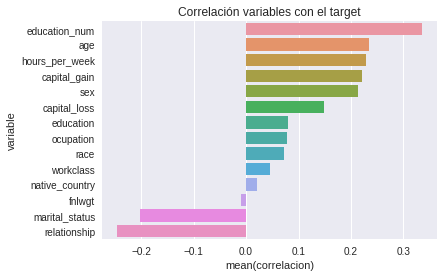

 tira  Index(['education'], dtype='object')
          variable  correlacion    abscor
2    education_num     0.335222  0.335222
10    relationship    -0.245576  0.245576
0              age     0.233656  0.233656
5   hours_per_week     0.228013  0.228013
3     capital_gain     0.221988  0.221988
12             sex     0.212999  0.212999
8   marital_status    -0.202259  0.202259


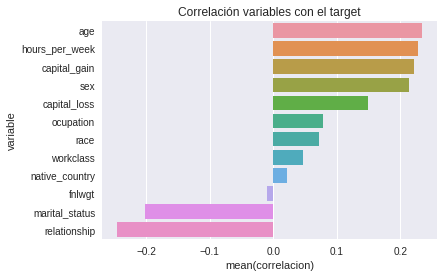

 tira  Index(['age', 'hours_per_week', 'sex'], dtype='object')
          variable  correlacion    abscor
8     relationship    -0.245576  0.245576
0              age     0.233656  0.233656
4   hours_per_week     0.228013  0.228013
2     capital_gain     0.221988  0.221988
10             sex     0.212999  0.212999
6   marital_status    -0.202259  0.202259


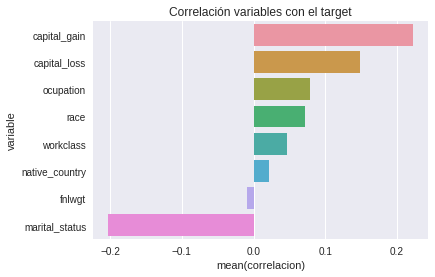

 tira  Index([], dtype='object')
         variable  correlacion    abscor
1    capital_gain     0.221988  0.221988
4  marital_status    -0.202259  0.202259


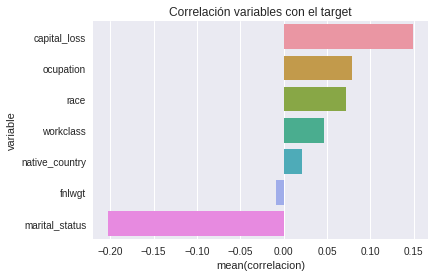

 tira  Index([], dtype='object')
         variable  correlacion    abscor
3  marital_status    -0.202259  0.202259


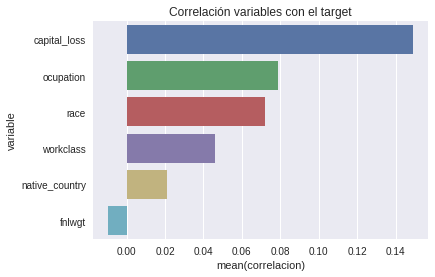

las variables seleccionadas son: ['education_num', 'relationship', 'capital_gain', 'marital_status']
[2, 10, 3, 8]


In [12]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous',Pipeline([("nums", ColumnExtractor(cols=(n))), ("sc",StandardScaler())])),
        ('factors',Pipeline([("cat", ColumnExtractor(cols=(c))), 
                             ("oe",MultiColumnLabelEncoder(columns=(list(range(len(c))))))])
)])),('func', FunctionTransformer(sel_column))])
trX_train=pipeline.fit_transform(X_train)#transformamos X_train con el pipeline

**De acuerdo con los resultados las variables más reacionadas con el ingreso son el nivel de educación i.e. a mayor nivel mayor ingreso, relationship i.e. depende si es casado o jefe de familia gana más por ejemplo, capital gain y su esado civil de forma negativa tiene que ver con la categoría como se etiquetó en este caso si no estas casado ganas menos por ejemplo.**

In [13]:
#array final con las variables seleccionadas
trX_train

array([[ 1.12836113,  0.        , -0.14504331,  2.        ],
       [-0.42254601,  0.        , -0.14504331,  2.        ],
       [-0.42254601,  3.        , -0.14504331,  0.        ],
       ..., 
       [-0.03481923,  3.        , -0.14504331,  0.        ],
       [-0.42254601,  4.        , -0.14504331,  0.        ],
       [-0.03481923,  0.        , -0.14504331,  2.        ]])

/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abraham/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

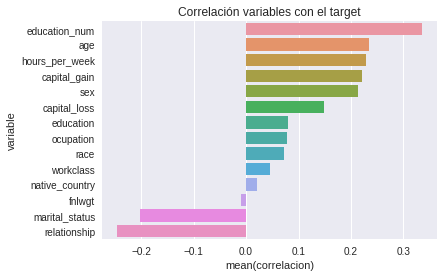

 tira  Index(['education'], dtype='object')
          variable  correlacion    abscor
2    education_num     0.335222  0.335222
10    relationship    -0.245576  0.245576
0              age     0.233656  0.233656
5   hours_per_week     0.228013  0.228013
3     capital_gain     0.221988  0.221988
12             sex     0.212999  0.212999
8   marital_status    -0.202259  0.202259


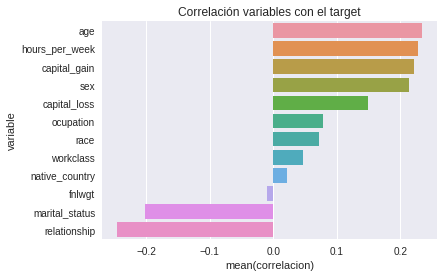

 tira  Index(['age', 'hours_per_week', 'sex'], dtype='object')
          variable  correlacion    abscor
8     relationship    -0.245576  0.245576
0              age     0.233656  0.233656
4   hours_per_week     0.228013  0.228013
2     capital_gain     0.221988  0.221988
10             sex     0.212999  0.212999
6   marital_status    -0.202259  0.202259


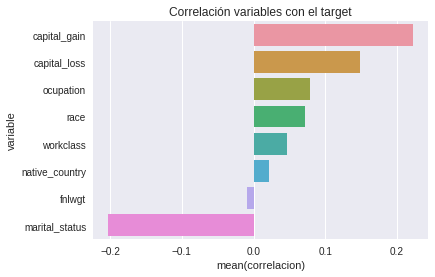

 tira  Index([], dtype='object')
         variable  correlacion    abscor
1    capital_gain     0.221988  0.221988
4  marital_status    -0.202259  0.202259


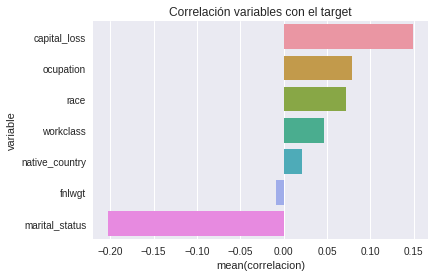

 tira  Index([], dtype='object')
         variable  correlacion    abscor
3  marital_status    -0.202259  0.202259


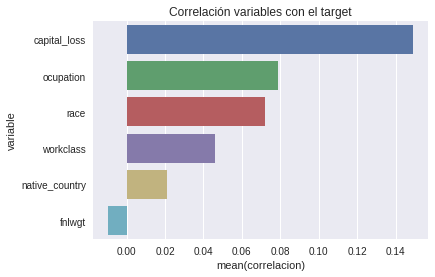

las variables seleccionadas son: ['education_num', 'relationship', 'capital_gain', 'marital_status']
[2, 10, 3, 8]


In [14]:
#Aplicamos transform a los datos de test con el pipeline, estos los ocuparemos para la parte 2
trx_test=pipeline.transform(X_test).astype('float64')

In [15]:
trx_test

array([[-0.42254601,  2.        , -0.14504331,  5.        ],
       [-0.8102728 ,  0.        , -0.14504331,  2.        ],
       [ 1.51608791,  3.        , -0.14504331,  4.        ],
       ..., 
       [ 1.12836113,  0.        ,  0.89498152,  2.        ],
       [-0.03481923,  0.        , -0.14504331,  2.        ],
       [ 1.12836113,  0.        , -0.14504331,  2.        ]])

## Pipeline 2

**Genera tu MagicLoop ocupando un RandomForest y un árbol para realizar la clasificación de income 
Prueba con los siguientes hiperparámetros utilizando el algoritmo GridSearch $\rightarrow$ NO se te olvide hacer cross-validation!!!**

**RandomForest: número de árboles: 500, 700, 800, 1000
número de árboles: 500, 700, 800, 1000
max_features: “auto”, “log2”
nodesize: 7, 11, 13, 15
Árboles:
nodesize: 7, 11, 13, 15**

Definimos primero la función que va a tomar los hiperparámetros y los modelos a probar en este caso un árbol y un random forest

In [16]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc,precision_recall_curve
from sklearn.metrics import roc_curve,average_precision_score,precision_score

/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


**Definimos una función para gráficos.**

In [17]:
def eval_offline(y_true,model,label,data):
    #función que pide respuestas, score y etiqueta equivalente el evento i.e. 1
    ###Gráficamos Curva ROC
    fpr, tpr, thresholds=roc_curve(y_true,model.predict_proba(data)[:,1],pos_label=label)
    win_auc=auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC win (area = %0.2f)' % win_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    ###Graficamos precision vs. recall, aquí aparecerá el AUC del modelo en datos de prueba(test)
    precision, recall, _ = precision_recall_curve(y_true, model.predict_proba(data)[:,1],pos_label=label)

    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()  
    


    
    print('El AREA BAJO LA CURVA AUC ES:',auc(fpr,tpr))
    
    
    

Función de double density

In [18]:
def acum(base,var):
    cum=np.zeros(len(base))
    for i in range(len(base)):
        if i==0:
            cum[i]=base[var].iloc[i]
        else:
            cum[i]=cum[i-1]+base[var].iloc[i]
    return(cum)

def plot_double_density(model,y_true,data):
    yy=LabelEncoder().fit_transform(y_true) 
    
    data=pd.DataFrame(np.array(model.predict_proba(data)[:,1]),columns=['score'])
    data['target']=np.array(yy)
    
    data['no_target'] = 1 - data.target


    data['total'] = data.target + data.no_target


    # ordenamos el dataframe descendente por score

    agg2 = (data.sort_values(by = 'score',ascending=False)).reset_index(drop = True)

    agg2['FPR'] = (agg2.no_target / agg2.target)

    agg2['event_rate'] = (agg2.target / agg2.total).apply('{0:.2%}'.format)

    # ks

    agg2['ks'] = np.round(((agg2.target / data.target.sum()).cumsum() - (agg2.no_target / data.no_target.sum()).cumsum()), 4) * 100

    # marcamos corte del ks

    flag = lambda x: '<----' if x == agg2.ks.max() else ''

    

    agg2['max_ks'] = agg2.ks.apply(flag)


    orig=float(agg2['target'].sum()/agg2['total'].sum()) 



    agg2['cumtotal']=acum(agg2,'total')
    agg2['cum_target']=acum(agg2,'target')
    agg2['cum_no_target']=acum(agg2,'no_target') 
    agg2['cum_FPR'] = (agg2.cum_no_target / agg2.cum_target).apply('{0:.2f}'.format) 
    agg2['cum_event_rate'] = (agg2.cum_target / agg2.cumtotal).apply('{0:.2%}'.format) 
    agg2['cum_TP'] = (agg2.cum_target / agg2['target'].sum()).apply('{0:.2%}'.format) 
    agg2['cum_FP'] = (agg2.cum_no_target / agg2['no_target'].sum()).apply('{0:.2%}'.format) 
    agg2['%Universo'] = (agg2.cumtotal / agg2.cumtotal.max()).apply('{0:.2%}'.format)
    agg2['LIFT'] = ((agg2.cum_target / agg2.cumtotal)/orig)

    agg2['Recall'] = (agg2.cum_target / agg2['target'].sum())
    agg2['Precision'] = (agg2.cum_target / agg2.cumtotal)
    agg2['FPrate'] = (agg2.cum_no_target / agg2['no_target'].sum()) 
    agg2['%Ctes'] = (agg2.cumtotal / agg2.cumtotal.max()) 
    
    plt.figure(figsize=(10,6))
    #plot de la distribución de los 1's (>50k) por score
    data[data['target']==1]['score'].plot.kde(label='>50k',xlim=[0,1])
    #plot de la distribución de los 0's (<=50k) por score
    data[data['target']==0]['score'].plot.kde(label='<=50k',xlim=[0,1])
    plt.legend()
    plt.xlabel('Score')#score es el predict de la clase 1(>50k)
    plt.title('Double Density')

   

    pass  

In [19]:
def define_hyper_params():
    """
        Esta función devuelve un diccionario con
        los clasificadores que vamos a utilizar y
        una rejilla de hiperparámetros
    """
    ## Por ejemplo
    # Create space of candidate learning algorithms and their hyperparameters
    classifier = {
         'DT': DecisionTreeClassifier()
     }
    
    search_space = [{'classifier': [DecisionTreeClassifier()],
                 'classifier__min_samples_split': [7, 11, 13, 15],
                 },
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [500, 700, 800, 1000],
                 'classifier__max_features': ['auto','log2'],
                 'classifier__min_samples_split': [7, 11, 13, 15]}]

    return (classifier,search_space)


Función magic_loop regresa los mejores parámetros para cada modelo a probar, en este caso un Random Forest y un árbol, usando un pipeline que pase los 2 modelos (árbol y Random Forest).

Para hacer el pipeline que compara modelos cons sus respectivos parámetros usamos esta fuente:
https://chrisalbon.com/machine-learning/model_selection_tuning_using_grid_search.html

In [20]:
def magic_loop(X_train, y_train,models_to_run=['DT','RF']):
    
    y=LabelEncoder().fit_transform(y_train)

   
    classifier,search_space=define_hyper_params()#Modelos y parámetros efinidos que vamos a usar
    #Hacemos 2  pipelines uno con las transformaciones como el pipeline 1 y otro con el con el árbol, se hace
    #en 2 porque dado las funciones que usamos juntar en 1 solo no funciona, el tema es que podriamos pasar otras
    #transformaciones pero tiene mas sentido ocupar las del fcb filtering para entrenar solo con las variables
    #importantes o seleccionadas.
    pipex = Pipeline([
    ('features', FeatureUnion([
        ('continuous',Pipeline([("nums", ColumnExtractor(cols=(n))), ("sc",StandardScaler())])),
        ('factors',Pipeline([("cat", ColumnExtractor(cols=(c))), 
                             ("oe",MultiColumnLabelEncoder(columns=(list(range(len(c))))))])
     )])),('func', FunctionTransformer(sel_column))])
    

    pipe = Pipeline([('classifier', classifier[models_to_run[0]])])
    
    #después en los parámetros vamos a probar el mejor modelo entre el árbol, el RF y sus parámetros respectivos
    #usando el gridsearch pero a diferencia de lo común, este nos va a comparar, usando cross-validation,
    #2 modelos y sus combinaciones de parámetros y nos regresará el mejor modelo con sus mejores parámetros.
    #hacemos 10 cross-validation y usamos F1-score como métrica de comparación. 
    clf = GridSearchCV(pipe, search_space, cv=10, verbose=3,scoring='f1',n_jobs=-1)
    #ajustamos el mejor modelo
    best_model = clf.fit(pipex.fit_transform(X_train), y)#ajustamos con el X?train transformada
    #obtenemos el mejor modelo y sus parámetros
    win=best_model.best_estimator_.get_params()['classifier']
    print('EL F1 SCORE DEL CROSS VAL DEL MODELO GANADOR ES:',best_model.best_score_)
    
    print('Mejor modelo fue:' ,win)
    return(win)#Regresa el mejor modelo             

De acuerdo con los resultados del pipeline1 nos vamos a quedar con las variables seleccionadas por nuestra función filtering, entonces vamos a darle de entrada al magic loop X's  y y's de entrenmiento.

**EVALUACION OFFLINE**

Primero generamos el modelo con magic loop:

/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tr

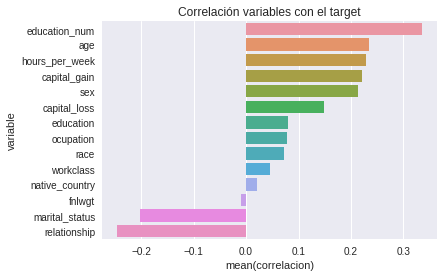

 tira  Index(['education'], dtype='object')
          variable  correlacion    abscor
2    education_num     0.335222  0.335222
10    relationship    -0.245576  0.245576
0              age     0.233656  0.233656
5   hours_per_week     0.228013  0.228013
3     capital_gain     0.221988  0.221988
12             sex     0.212999  0.212999
8   marital_status    -0.202259  0.202259


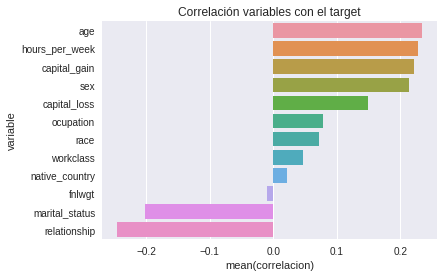

 tira  Index(['age', 'hours_per_week', 'sex'], dtype='object')
          variable  correlacion    abscor
8     relationship    -0.245576  0.245576
0              age     0.233656  0.233656
4   hours_per_week     0.228013  0.228013
2     capital_gain     0.221988  0.221988
10             sex     0.212999  0.212999
6   marital_status    -0.202259  0.202259


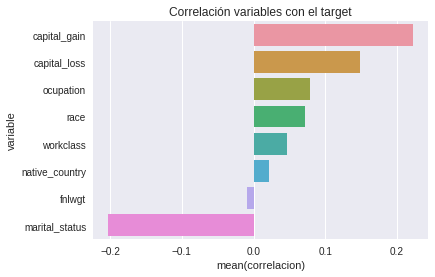

 tira  Index([], dtype='object')
         variable  correlacion    abscor
1    capital_gain     0.221988  0.221988
4  marital_status    -0.202259  0.202259


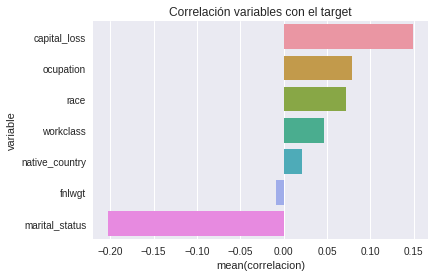

 tira  Index([], dtype='object')
         variable  correlacion    abscor
3  marital_status    -0.202259  0.202259


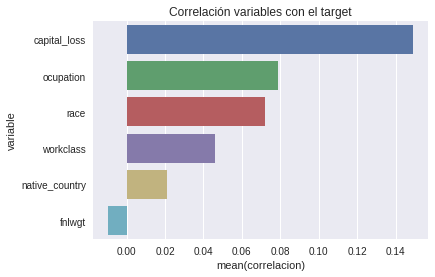

las variables seleccionadas son: ['education_num', 'relationship', 'capital_gain', 'marital_status']
[2, 10, 3, 8]
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), classifier__min_samples_split=7 
[CV] classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), classifier__min_samples_split=7 

[CV] classifier=Decis

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s


[CV]  classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), classifier__max_features=auto, classifier__min_samples_split=7, classifier__n_estimators=500, score=0.634091 -   8.1s
[CV] classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clas

[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed: 12.3min


[CV]  classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), classifier__max_features=log2, classifier__min_samples_split=15, classifier__n_estimators=500, score=0.633295 -  21.2s
[CV]  classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), cla

[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 14.7min finished


EL F1 SCORE DEL CROSS VAL DEL MODELO GANADOR ES: 0.6318416128964051
Mejor modelo fue: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [21]:
winner=magic_loop(X_train, y_train,models_to_run=['DT','RF'])#Resultados del magic Loop

Generamos las gráficas ROC, precision-recall, double density, además de ver el AUC, **TODO ESTO CON LOS DATOS DE TEST** HOLD OUT

/home/abraham/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


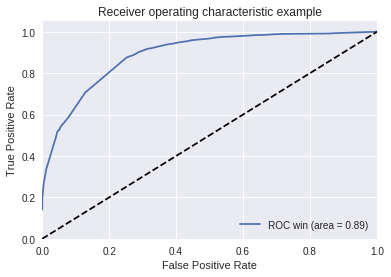

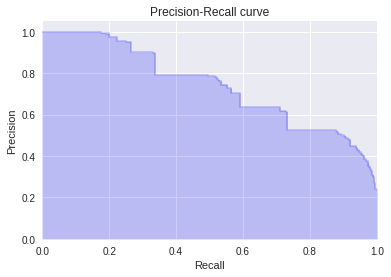

El AREA BAJO LA CURVA AUC ES: 0.891116339185


/home/abraham/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


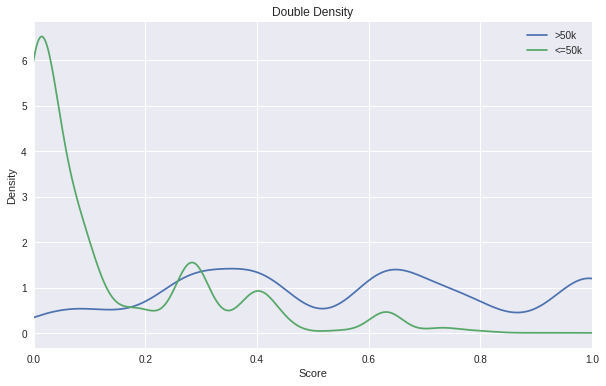

In [22]:
#tenemos modelo ganador y lo ajustamos
#ajustamos el modelo al x_train transformado(trx_rain,que es el que le pasamos el pipeline1)
#trX_train=pipeline.fit_transform(X_train)
#trx_test=pipeline.fit_transform(X_test), se aplico en el pipeline1 
winner.fit(trX_train, y_train)
eval_offline(y_test,winner,'>50K',trx_test)
plot_double_density(winner,y_test,trx_test)

Los modelos por default tienen un threshold o punto de corte en 0.5, bajo este corte podemos ver lo siguiente:

**Curva ROC**.-Podemos observar que con un 5% de falsos positivos podemos capturar el 53% de los individuos(Recall) que ganan más de 50k(nuestros 1's).

**Gráfica Precision-Recall**.-vemos que para el 53% de rcall tenemos una Precisión de casi el 80%

**Double Densisty**.-en este gráfico podemos observar que para los 0's individuos que ganan menos de 50K los scores son bajos lo cual es esperado, pero la distribución para los que ganan más de 50k parece más uniforme y esperábamos más sesgaa a la derecha, esto puede debers a que quizás neesitamos utilizar más variables, o transformar de modo diferente.

Sin embargo, todo lo explicado anteriormente lo podemos ver más claro haciendo la matriz de confusión:

    Nota. Tomamos el modelo de salida del magic loop y evaluamos en test

In [23]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

winner.fit(trX_train, y_train) 
pred=winner.predict(trx_test) 
from sklearn.metrics import classification_report,confusion_matrix 
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

/home/abraham/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


             precision    recall  f1-score   support

      <=50K       0.86      0.95      0.90      7415
       >50K       0.77      0.53      0.63      2354

avg / total       0.84      0.85      0.84      9769

[[7038  377]
 [1110 1244]]


Accuracy del modelo.

In [26]:
(1244+7038)/(1244+1110+377+7038)

0.8477838059166752

Podemos ver que el modelo clasifica correctamente el 84% de los individuos, también la matriz de confusión nos dice que el 77% de los individuos que clasificamos como más de 50k efectivamente los ganan,y el F1-score de estos es de .63 muy parecido a lo que nos dió el magic loop con el cross validation.

**MODELO GANADOR Y SUS HIPERPARÁMETROS....**

In [25]:
winner

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

** CONCLUSIONES: **

Se cumplio el objetivo de aprendizaje para determinar quien esta en la parte superior o inferior de la barrera de los 50k, con el modelo desarrollado podemos ingresar nuevos individuos y predecir con una gran certeza de que lado de la barrera se encuentran. Si se extiende el "censo" o si se desea explorar más aún, es posible generar clasificaciones de una forma rapida y segura. 

Los modelos seleccionados ajustan bien a nuestros datos, sin embargo podemos recomendar una par de modelos adicionales, como podrian ser una Red Neuronal y una Regresión Logística, ya que en base a nuestra experiencia son modelos que podrian competir para obtener predicciones mas precisas aún. También sugerimos realizar una liempieza mas rigurosa de los datos, posiblemente cambiar el método de recolección de la muestra.

Las versiones de *R* y *Python* que utilizamos fueron para este caso herramientas optimas para el tratamiento de los datos y análisis requerido, es un ejemplo muy claro donde no es necesario herramientas mas robustas para tener buenos resultados. Las paqueterias de *R* y las funciones de *scikit-learn* son excelentes herramientas con funcionamientos muy optimos, donde su uso simplifico mucho el desarrollo y análisis de la solución.